## 賃料についてのドメイン知識


- https://lobotomy-project.org/marketpricerent/
- https://ameblo.jp/enjoytokyolovelivelife/entry-11084920720.html


## パッケージインポート

In [99]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib
font = {'family': 'Yu Mincho'}
matplotlib.rc('font', **font)

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from tqdm import tqdm

import os
import gc
print(os.listdir("../input"))
print(os.listdir("../submit"))

['data', 'line.csv', 'location 保存用.txt', 'location.csv', 'location.txt', 'station 保存用.txt', 'station.csv', 'station.txt', 'test.csv', 'tokyo23', 'train.csv']
['sample_submit.csv', 'score.xlsx', 'submit1.csv', 'submit2.csv', 'submit3.csv', 'submit4.csv', 'submit5.csv', 'submit6.csv']


## データ読み込み

In [365]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submit = pd.read_csv('../submit/sample_submit.csv')

In [366]:
train = train.rename(columns={'賃料':'target','所在地':'location','アクセス':'access',
                              '間取り':'floor_plan','築年数':'age','方角':'direction','面積':'area','所在階':'Floor',
                              'バス・トイレ':'Bath_Toilet','キッチン':'kitchen','放送・通信':'broadcast','室内設備':'facilities',
                              '駐車場':'parking','周辺環境':'env','建物構造':'structure','契約期間':'C_year'})

test = test.rename(columns={'所在地':'location','アクセス':'access',
                              '間取り':'floor_plan','築年数':'age','方角':'direction','面積':'area','所在階':'Floor',
                              'バス・トイレ':'Bath_Toilet','キッチン':'kitchen','放送・通信':'broadcast','室内設備':'facilities',
                              '駐車場':'parking','周辺環境':'env','建物構造':'structure','契約期間':'C_year'})
## 欠損値を埋める
train = train.fillna('-')
test = test.fillna('-')

In [367]:
#train['Flag'] = 1
#test['Flag'] = 0
#df = pd.concat([train,test])

## データ概要

In [189]:
## データの概要
def resumetable(df):
    print(f'Dataset Shape:{df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary ['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name']==name, 'Entoropy'] = round(stats.entropy(df[name].value_counts(normalize=True),base=2),2)
        
    return summary

## 欠損値
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent],axis=1, keys=['Total','Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return np.transpose(tt)

## 外れ値
def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('lower : ', lower, ' upper : ',upper)
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [104]:
print('訓練データ : ', train.shape)
print('テストデータ : ',test.shape)

訓練データ :  (31470, 18)
テストデータ :  (31262, 17)


In [105]:
resumetable(train)

Dataset Shape:(31470, 18)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entoropy
0,id,int64,0,31470,1,2,3,14.94
1,target,int64,0,871,75000,76000,110000,7.93
2,location,object,0,11333,東京都北区滝野川３丁目,東京都中央区月島３丁目,東京都渋谷区笹塚２丁目,12.62
3,access,object,0,24172,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,14.26
4,floor_plan,object,0,30,1K,1R,1K,2.77
5,age,object,0,746,9年9ヶ月,44年10ヶ月,8年6ヶ月,8.56
6,direction,object,2749,8,南東,NaN,南,2.73
7,area,object,0,5739,20.01m2,16.5m2,22.05m2,11.50
8,Floor,object,0,1032,1階／12階建,5階／10階建,12階／15階建,6.35
9,Bath_Toilet,object,329,360,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,専用トイレ／\tシャワー／\t温水洗浄便座,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,5.77


In [106]:
resumetable(test)

Dataset Shape:(31262, 17)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entoropy
0,id,int64,0,31262,31471,31472,31473,14.93
1,location,object,0,11191,東京都世田谷区深沢５丁目1-27,東京都目黒区八雲１丁目11-8,東京都豊島区池袋本町２丁目22-2,12.61
2,access,object,0,24173,東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...,東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...,東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...,14.28
3,floor_plan,object,0,37,2LDK,1R,1K,2.79
4,age,object,0,734,49年0ヶ月,0年2ヶ月,23年4ヶ月,8.58
5,direction,object,2808,8,南,南東,南東,2.73
6,area,object,0,5746,50.22m2,20.88m2,26.93m2,11.50
7,Floor,object,1,1020,8階／8階建,3階／4階建,1階／4階建,6.35
8,Bath_Toilet,object,320,353,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,5.80
9,kitchen,object,635,379,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,ガスコンロ／\t給湯,5.54


In [138]:
## 欠損値を埋める
df = df.fillna('-')

## 特徴量について

### 賃料

In [368]:
CalcOutliers(train['target'])

lower :  -102952.58921692356  upper :  339533.2020545467
Identified lowest outliers: 0
Identified upper outliers: 437
Total outlier observations: 437
Non-outlier observations: 31033
Total percentual of Outliers:  1.4082


In [140]:
train.query('target>339533').head()

,id,target,location,access,floor_plan,age,direction,area,Floor,Bath_Toilet,kitchen,broadcast,facilities,parking,env,structure,year
22,23,346000,東京都中央区佃１丁目,有楽町線\t月島駅\t徒歩6分\t\t京葉線(東京－蘇我)\t越中島駅\t徒歩11分\t\t...,2LDK,30年4ヶ月,北西,81.2m2,10階／42階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t独立キッチン,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\t24時間換気システム\t／\t...,駐輪場\t空有,NaN,SRC（鉄骨鉄筋コンクリート）,NaN
171,172,415000,東京都渋谷区恵比寿４丁目,山手線\t恵比寿駅\t徒歩8分\t\t山手線\t目黒駅\t徒歩14分\t\t日比谷線\t広尾...,2LDK,25年0ヶ月,北,75.96m2,3階／13階建（地下2階）,バス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\tIHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t給湯,光ファイバー／\tCSアンテナ／\tBSアンテナ／\t有線放送,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\t24時間換気システム\t／\t...,"駐車場\t空有\t46,440円\t駐輪場\t空有\tバイク置き場\t無",【小学校】 180m\t【学校】 1600m\t【スーパー】 700m\t【コンビニ】 24...,SRC（鉄骨鉄筋コンクリート）,2年間
242,243,340000,東京都中央区月島１丁目,有楽町線\t月島駅\t徒歩1分\t\t都営大江戸線\t勝どき駅\t徒歩10分\t\t京葉線越...,3LDK,16年0ヶ月,南東,89.83m2,10階／32階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tシステムキッチン\t／\t給湯,光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付／\t床暖房\tトランクルーム\t／\tウォークインクローゼット\tシューズボック...,"駐車場\t空有\t35,000円(税込)",【コンビニ】 90m\t【スーパー】 230m,RC（鉄筋コンクリート）,NaN
258,259,468000,東京都中央区勝どき６丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩14分\t\t日比谷線...,2LDK,11年7ヶ月,南西,96.34m2,30階／58階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t独立キッチン,インターネット対応／\t高速インターネット／\t光ファイバー／\tCATV,冷房／\tエアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフ...,NaN,NaN,RC（鉄筋コンクリート）,NaN
274,275,650000,東京都品川区上大崎３丁目1-30,山手線\t目黒駅\t徒歩2分\t\t東急目黒線\t不動前駅\t徒歩12分\t\t南北線\t白...,3LDK,2年1ヶ月,北東,79.91m2,30階／38階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\tカウンターキッチン\t／\t給湯,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,冷房／\tエアコン付／\t床暖房\tトランクルーム\tシューズボックス／\tバルコニー／\t...,"駐車場\t空有\t45,000円\t(※サイズ・空き要確認)",【スーパー】 171m\t【銀行】 114m\t【コンビニ】 137m\t【ドラッグストア】...,RC（鉄筋コンクリート）,4年間\t※この物件は\t定期借家\tです。



 mu = 118290.31 and sigma = 73747.63



((array([-4.08513702, -3.87431282, -3.75917019, ...,  3.75917019,
          3.87431282,  4.08513702]),
  array([  25000,   26000,   26200, ..., 1660000, 1800000, 2500000],
        dtype=int64)),
 (60430.90500715401, 118290.30641881158, 0.8193248084817133))

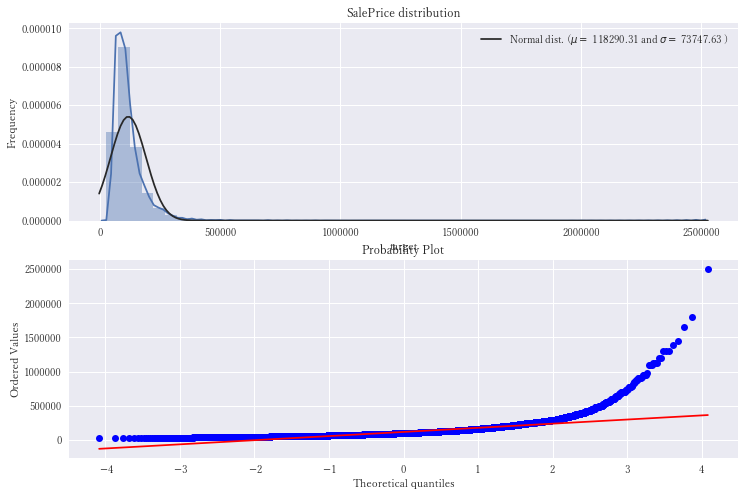

In [141]:
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(train['target'],fit=norm)
(mu,sigma) = norm.fit(train['target'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(train['target'],plot=plt)

### log(賃料)


 mu = 11.56 and sigma = 0.46



((array([-4.08513702, -3.87431282, -3.75917019, ...,  3.75917019,
          3.87431282,  4.08513702]),
  array([10.1266711 , 10.16589028, 10.17355286, ..., 14.32232876,
         14.40329778, 14.73180169])),
 (0.45420385928064183, 11.562303507629348, 0.9892433316118495))

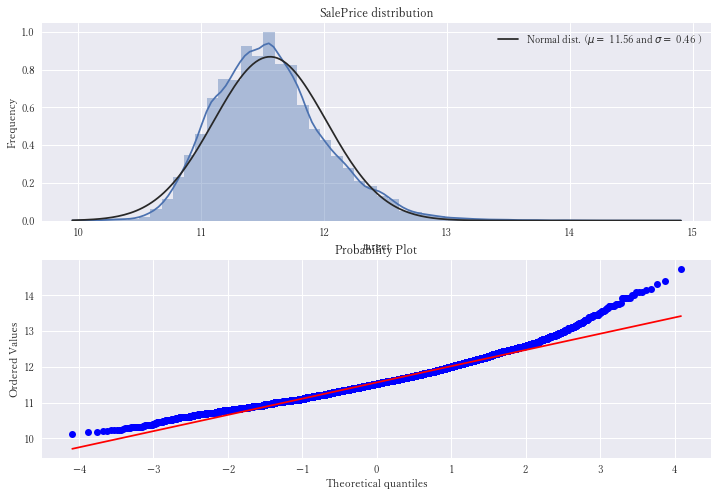

In [142]:
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(np.log1p(train['target']),fit=norm)
(mu,sigma) = norm.fit(np.log1p(train['target']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(np.log1p(train['target']),plot=plt)

### Box-cox変換

In [350]:
import sympy
def re_boxcox(target,best_lam=best_lam):
    return round(sympy.root(target*best_lam+1,best_lam))

In [351]:
best_lam = -0.35
train['target_boxcox'] = stats.boxcox(train.target, lmbda=best_lam)
train['target_re_box'] = train.target_boxcox.map(re_boxcox)

In [352]:
train[['target','target_boxcox','target_re_box']].head()

,target,target_boxcox,target_re_box
0,75000,2.800953,75000
1,76000,2.801213,76000
2,110000,2.808002,110000
3,150000,2.813057,150000
4,74000,2.800688,74000


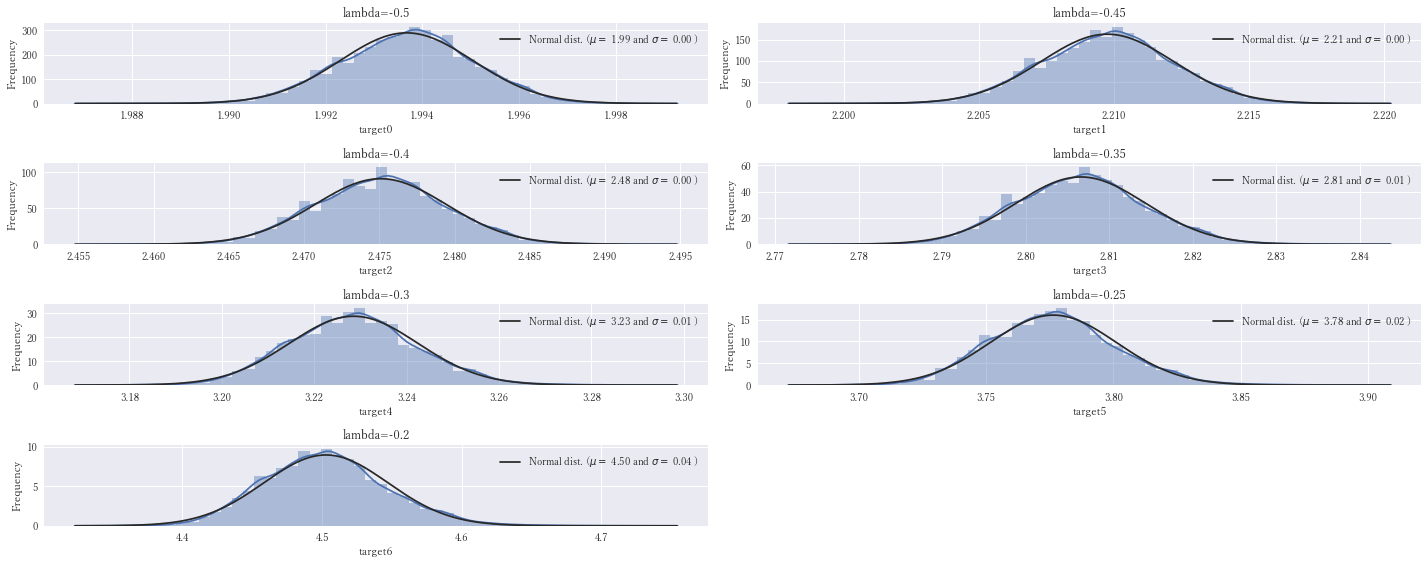

In [340]:
fig = plt.figure(figsize=(20, 8))

list_lambda = [-0.5, -0.45,-0.4, -0.35, -0.3, -0.25, -0.2]
for i, lambda_ in enumerate(list_lambda):
    train['target'+str(i)] = stats.boxcox(train.target, lmbda=lambda_)
    fig.add_subplot(4, 2, i+1)
    g = sns.distplot(train['target'+str(i)],fit=norm)
    (mu,sigma) = norm.fit(train['target'+str(i)])
    g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
    g.set_ylabel('Frequency')
    g.set_title('lambda='+str(lambda_))

fig.tight_layout()
fig.show()
plt.show()


 mu = 2.81 and sigma = 0.01



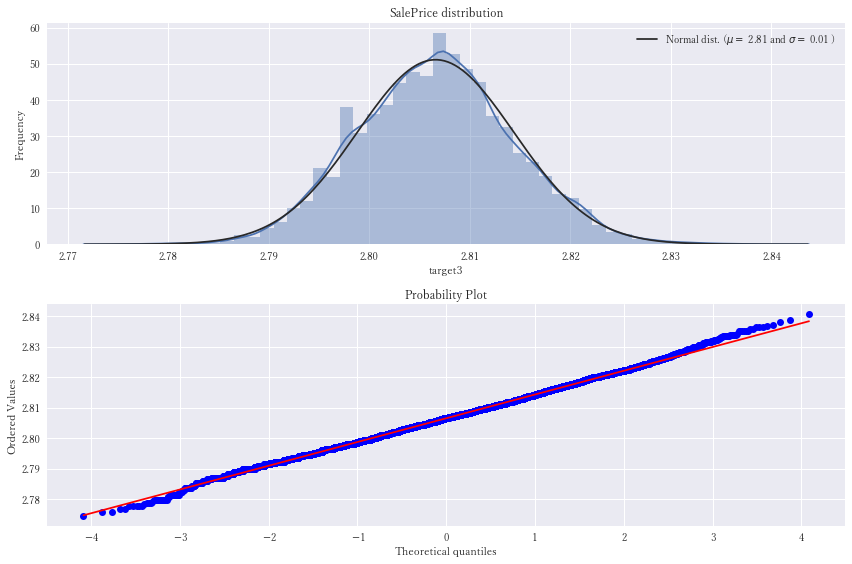

In [342]:
fe = 'target3'
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(train[fe],fit=norm)
(mu,sigma) = norm.fit(train[fe])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(train[fe],plot=plt)
plt.tight_layout()
plt.show()

### 所在地

#### 緯度経度追加

In [360]:
loc = pd.read_table('../input/location.txt',encoding='cp932',delimiter=',')
## -の正規化
train['location'] = train['location'].apply(lambda x: x.replace('−','－'))
test['location'] = test['location'].apply(lambda x: x.replace('−','－'))
loc['location'] = loc['location'].apply(lambda x: x.replace('−','－'))

## lon, latのマッピング
lat_map = loc.groupby('location')[' lat'].max()
lon_map = loc.groupby('location')[' lon'].max()
train['loc_lat'] = train.location.map(lat_map)
train['loc_lon'] = train.location.map(lon_map)

test['loc_lat'] = test.location.map(lat_map)
test['loc_lon'] = test.location.map(lon_map)

In [282]:
sample = train.sample(n=300)

In [283]:
## 賃貸を地図に表示
import folium

map = folium.Map(location=[35.638697, 139.683262], zoom_start=11)
 
for i, r in sample.iterrows():
    folium.CircleMarker(location=[r['loc_lat'], r['loc_lon']],popup=r['target'], 
                        color='crimson',fill=True,radius=r['target']/50000).add_to(map)

folium.Marker(location=[35.6759323, 139.7450316]).add_to(map)
map

In [361]:
## 緯度経度のサインコサイン変換
from math import sin, cos,radians
train['sin_loc_lat'] = train.loc_lat.apply(lambda x: sin(radians(x)))
train['cos_loc_lon'] = train.loc_lon.apply(lambda x: cos(radians(x)))
test['sin_loc_lat'] = test.loc_lat.apply(lambda x: sin(radians(x)))
test['cos_loc_lon'] = test.loc_lon.apply(lambda x: cos(radians(x)))

In [362]:
## 距離を求める関数
# 国会議事堂の緯度経度[35.6759323, 139.7450316]
import math
import pyproj
from geopy.distance import great_circle, vincenty

# 赤道半径をWGS84準拠で設定
g = pyproj.Geod(ellps='WGS84')

train['center_dis'] = train.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(35.6759323, 139.7450316)).meters, axis=1)
test['center_dis'] = test.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(35.6759323, 139.7450316)).meters, axis=1)


 mu = 8779.02 and sigma = 3657.64



((array([-4.08512227, -3.87429734, -3.75915429, ...,  3.75915429,
          3.87429734,  4.08512227]),
  array([  626.90924822,   626.90924822,   626.90924822, ...,
         18443.17261989, 18617.78500681, 18617.78500681])),
 (3629.2136187044534, 8779.023805159884, 0.9921033018234434))

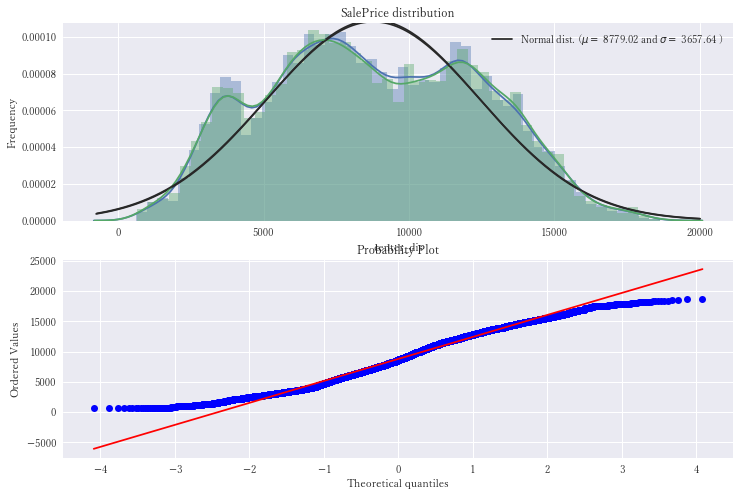

In [363]:
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(train['center_dis'],fit=norm)
g = sns.distplot(test['center_dis'],fit=norm)
(mu,sigma) = norm.fit(train['center_dis'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(train['center_dis'],plot=plt)

<Figure size 864x576 with 0 Axes>

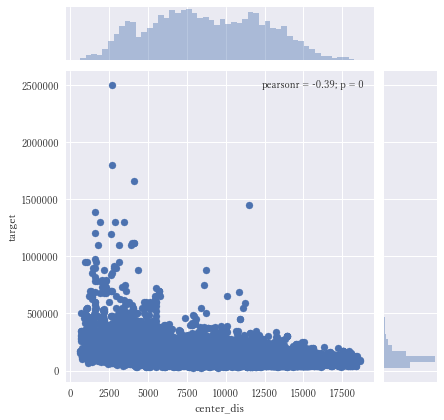

In [364]:
plt.figure(figsize=(12,8))
sns.jointplot(x='center_dis',y='target',data=train)

#### 都道府県で分ける

In [152]:
import jaconv
train['location'] = train.location.apply(lambda x: jaconv.z2h(x,digit=True,ascii=True))
test['location'] = test.location.apply(lambda x: jaconv.z2h(x,digit=True,ascii=True))

In [153]:
train['Flag'] = 1
test['Flag'] = 0
df = pd.concat([train,test])

In [154]:
## 東京都という文字を抜く
df['location'] = df['location'].apply(lambda x: x.replace('東京都','').replace('（','').replace('）',''))
df['location_'] = df.location.apply(lambda x: 1 if '-' in x else 0)
df_loc = df.query('location_==1').drop('location_',axis=1)
df.drop('location_',axis=1,inplace=True)

In [156]:
df_loc[['location','Floor','floor_plan','area','facilities','target']].sort_values(by='location')

,location,Floor,floor_plan,area,facilities,target
9628,世田谷区三宿1丁目14-(10),3階／3階建,1K+S(納戸),37.26m2,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気...,109000.0
280,世田谷区三宿1丁目14-(10),1階／3階建,1K+S(納戸),22.98m2,冷房／\tエアコン付\t床下収納\tシューズボックス／\tフローリング／\t24時間換気シス...,101000.0
26259,世田谷区三宿1丁目14-(10),2階／3階建,1K+S(納戸),30.01m2,冷房／\tエアコン付\tシューズボックス／\tフローリング／\t24時間換気システム\t／\...,NaN
10562,世田谷区三宿1丁目14-(10),1階／3階建,1K+S(納戸),21.12m2,冷房／\tエアコン付\t床下収納\tシューズボックス／\tフローリング／\t24時間換気シス...,101000.0
10192,世田谷区三宿1丁目14-(10),1階／3階建,1K+S(納戸),25.67m2,冷房／\tエアコン付\t床下収納\tシューズボックス／\tフローリング／\t24時間換気シス...,NaN
16380,世田谷区三宿1丁目14-(10),2階／3階建,1K+S(納戸),28.56m2,冷房／\tエアコン付\tシューズボックス／\tフローリング／\t24時間換気システム\t／\...,NaN
9949,世田谷区三宿1丁目14-10,1階／3階建,1K+S(納戸),21.12m2,エアコン付\t床下収納\tシューズボックス／\t24時間換気システム\t／\t室内洗濯機置場...,101000.0
29267,世田谷区三宿1丁目14-10,1階／3階建,1K+S(納戸),22.98m2,エアコン付\t床下収納\tシューズボックス／\t24時間換気システム\t／\t室内洗濯機置場...,NaN
21391,世田谷区三宿1丁目14-10,3階／3階建,1K+S(納戸),37.26m2,エアコン付\tシューズボックス／\tバルコニー／\t24時間換気システム\t／\t室内洗濯機...,109000.0
19124,世田谷区三宿1丁目14-10,2階／3階建,1K+S(納戸),28.56m2,エアコン付\tシューズボックス／\t24時間換気システム\t／\t室内洗濯機置場\t公営水道...,104000.0


同じアパート、マンションならばほぼ賃料は一緒

#### 市区町村で分ける

- [東京23区の賃料の相場](https://chintaibest.com/yachin/)

In [158]:
siku = ["千代田区","中央区","港区","新宿区","文京区","台東区","墨田区","江東区","品川区","目黒区","大田区","世田谷区","渋谷区","中野区",
        "杉並区","豊島区","北区","荒川区","板橋区","練馬区","足立区","葛飾区","江戸川区","八王子市","立川市","武蔵野市","三鷹市","青梅市",
        "府中市","昭島市","調布市","町田市","小金井市","小平市","日野市","東村山市","国分寺市","国立市","福生市","狛江市","東大和市",
        "清瀬市","東久留米市","武蔵村山市","多摩市","稲城市","羽村市","あきる野市","西東京市","瑞穂町","日の出町","檜原村","奥多摩町","大島町",
        "利島村","新島村","神津島村","三宅村","御蔵島村","八丈町","青ヶ島村","小笠原村",]

train['city'] = train['location'].apply(lambda x: [s for s in siku if s in x][0])
test['city'] = test['location'].apply(lambda x: [s for s in siku if s in x][0])

23区内だけやないかい

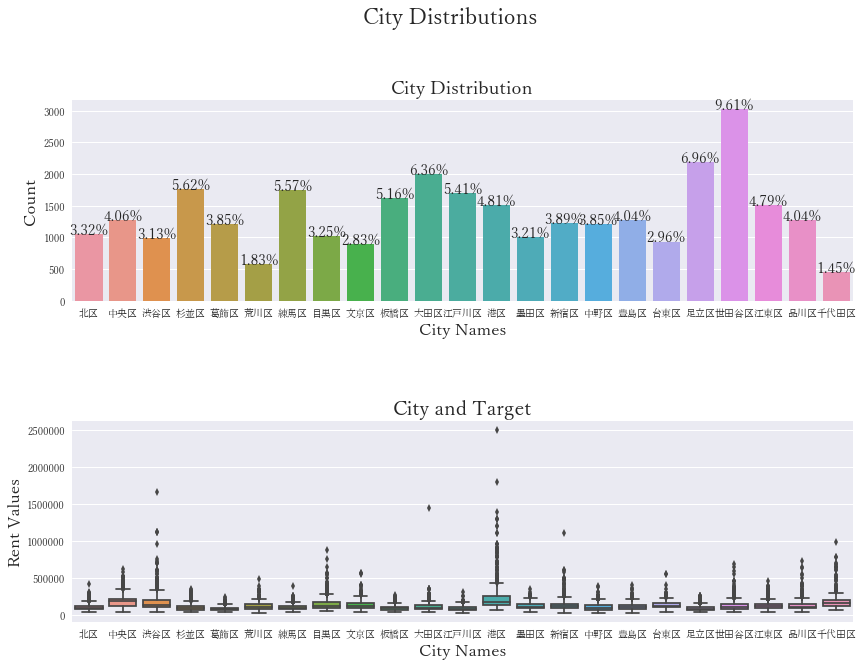

In [159]:
total = len(train)

plt.figure(figsize=(14,10))
plt.suptitle('City Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='city', data=train,)
g.set_title("City Distribution", fontsize=19)
g.set_xlabel("City Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='city', y='target', data=train)
g2.set_title("City and Target", fontsize=20)
g2.set_xlabel("City Names", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [160]:
train.groupby('city').target.describe().sort_values('50%')

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
葛飾区,1212.0,79114.657591,26833.282240,29000.0,60000.0,72500.0,93500.0,240000.0
足立区,2191.0,85872.540849,31381.911148,35000.0,63000.0,79000.0,101500.0,256000.0
江戸川区,1702.0,86592.302585,29777.014665,26000.0,65000.0,80000.0,106000.0,300000.0
板橋区,1624.0,90003.879310,32523.361958,28000.0,67000.0,85000.0,105000.0,262000.0
練馬区,1752.0,92724.943493,33092.588718,29000.0,70000.0,87000.0,111000.0,388000.0
杉並区,1769.0,97708.174675,44761.635854,32000.0,65500.0,87000.0,115000.0,340000.0
北区,1045.0,99506.602871,45337.323020,31000.0,70000.0,89000.0,115000.0,420000.0
中野区,1211.0,101578.398018,45599.679076,27000.0,68000.0,92000.0,122750.0,385000.0
大田区,2000.0,106981.675000,52990.714596,28000.0,78000.0,95000.0,123000.0,1450000.0


#### クラスタリング

In [161]:
city_cluster = {'世田谷区': 4,'中央区': 3, '中野区': 6, '北区': 6, '千代田区': 3, '台東区': 1, '品川区': 5, '墨田区': 1, '大田区': 4,
                 '文京区': 1, '新宿区': 5, '杉並区': 0,'板橋区': 0, '江戸川区': 0, '江東区': 5, '渋谷区': 3, '港区': 2, '目黒区': 1,
                 '練馬区': 0, '荒川区': 1, '葛飾区': 6, '豊島区': 6, '足立区': 0}
train['cluster'] = train.city.map(city_cluster)
test['cluster'] = test.city.map(city_cluster)

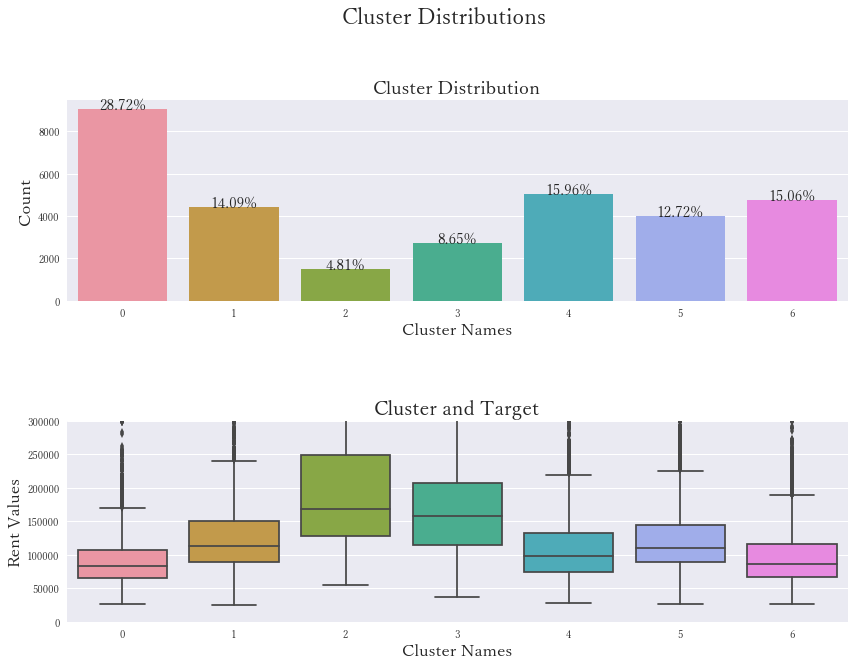

In [163]:
total = len(train)

plt.figure(figsize=(14,10))
plt.suptitle('Cluster Distributions', fontsize=22)

plt.subplot(211)
g = sns.countplot(x='cluster', data=train,)
g.set_title("Cluster Distribution", fontsize=19)
g.set_xlabel("Cluster Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(212)
g2 = sns.boxplot(x='cluster', y='target', data=train)
g2.set_title("Cluster and Target", fontsize=20)
g2.set_xlabel("Cluster Names", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)
g2.set_ylim(0,300000)
plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [ ]:
train.groupby('cluster').target.describe().sort_values('50%')

#### 様々な区の情報

In [164]:
df1 = pd.read_csv('../input/tokyo23/area.csv',encoding='utf-8')
df2 = pd.read_csv('../input/tokyo23/daytime_popu.csv',encoding='utf-8')
df3 = pd.read_csv('../input/tokyo23/dwelling.csv',encoding='utf-8')
df4 = pd.read_csv('../input/tokyo23/households.csv',encoding='utf-8')
df5 = pd.read_csv('../input/tokyo23/income.csv',encoding='utf-8')
df6 = pd.read_csv('../input/tokyo23/move_popu.csv',encoding='utf-8')
df7 = pd.read_csv('../input/tokyo23/office.csv',encoding='utf-8')
df8 = pd.read_csv('../input/tokyo23/population.csv',encoding='utf-8')
df9 = pd.read_csv('../input/tokyo23/popu_tran.csv',encoding='shift-jis')
df10 = pd.read_csv('../input/tokyo23/revenue.csv',encoding='utf-8')
df11 = pd.read_csv('../input/tokyo23/households_num.csv',encoding='utf-8')

data = pd.merge(df1,df2,on='地域',how='outer')
data = pd.merge(data,df3,on='地域',how='outer')
data = pd.merge(data,df4,on='地域',how='outer')
data = pd.merge(data,df5,on='地域',how='outer')
data = pd.merge(data,df6,on='地域',how='outer')
data = pd.merge(data,df7,on='地域',how='outer')
data = pd.merge(data,df8,on='地域',how='outer')
data = pd.merge(data,df9,on='地域',how='outer')
data = pd.merge(data,df10,on='地域',how='outer')
data = pd.merge(data,df11,on='地域',how='outer')

data = data.rename(columns={'地域':'city'})
data = data.query('city!="区部"')

data = data[['city','総面積','昼間人口','住居総数','年収','事業所数','2020年','総世帯数']]

In [171]:
for f in ['総面積','昼間人口','住居総数','年収','事業所数','2020年','総世帯数']:
    city_map = data.groupby('city')[f].mean().to_dict()
    train[f] = train.city.map(city_map)
    test[f] = test.city.map(city_map)

<Figure size 1080x864 with 0 Axes>

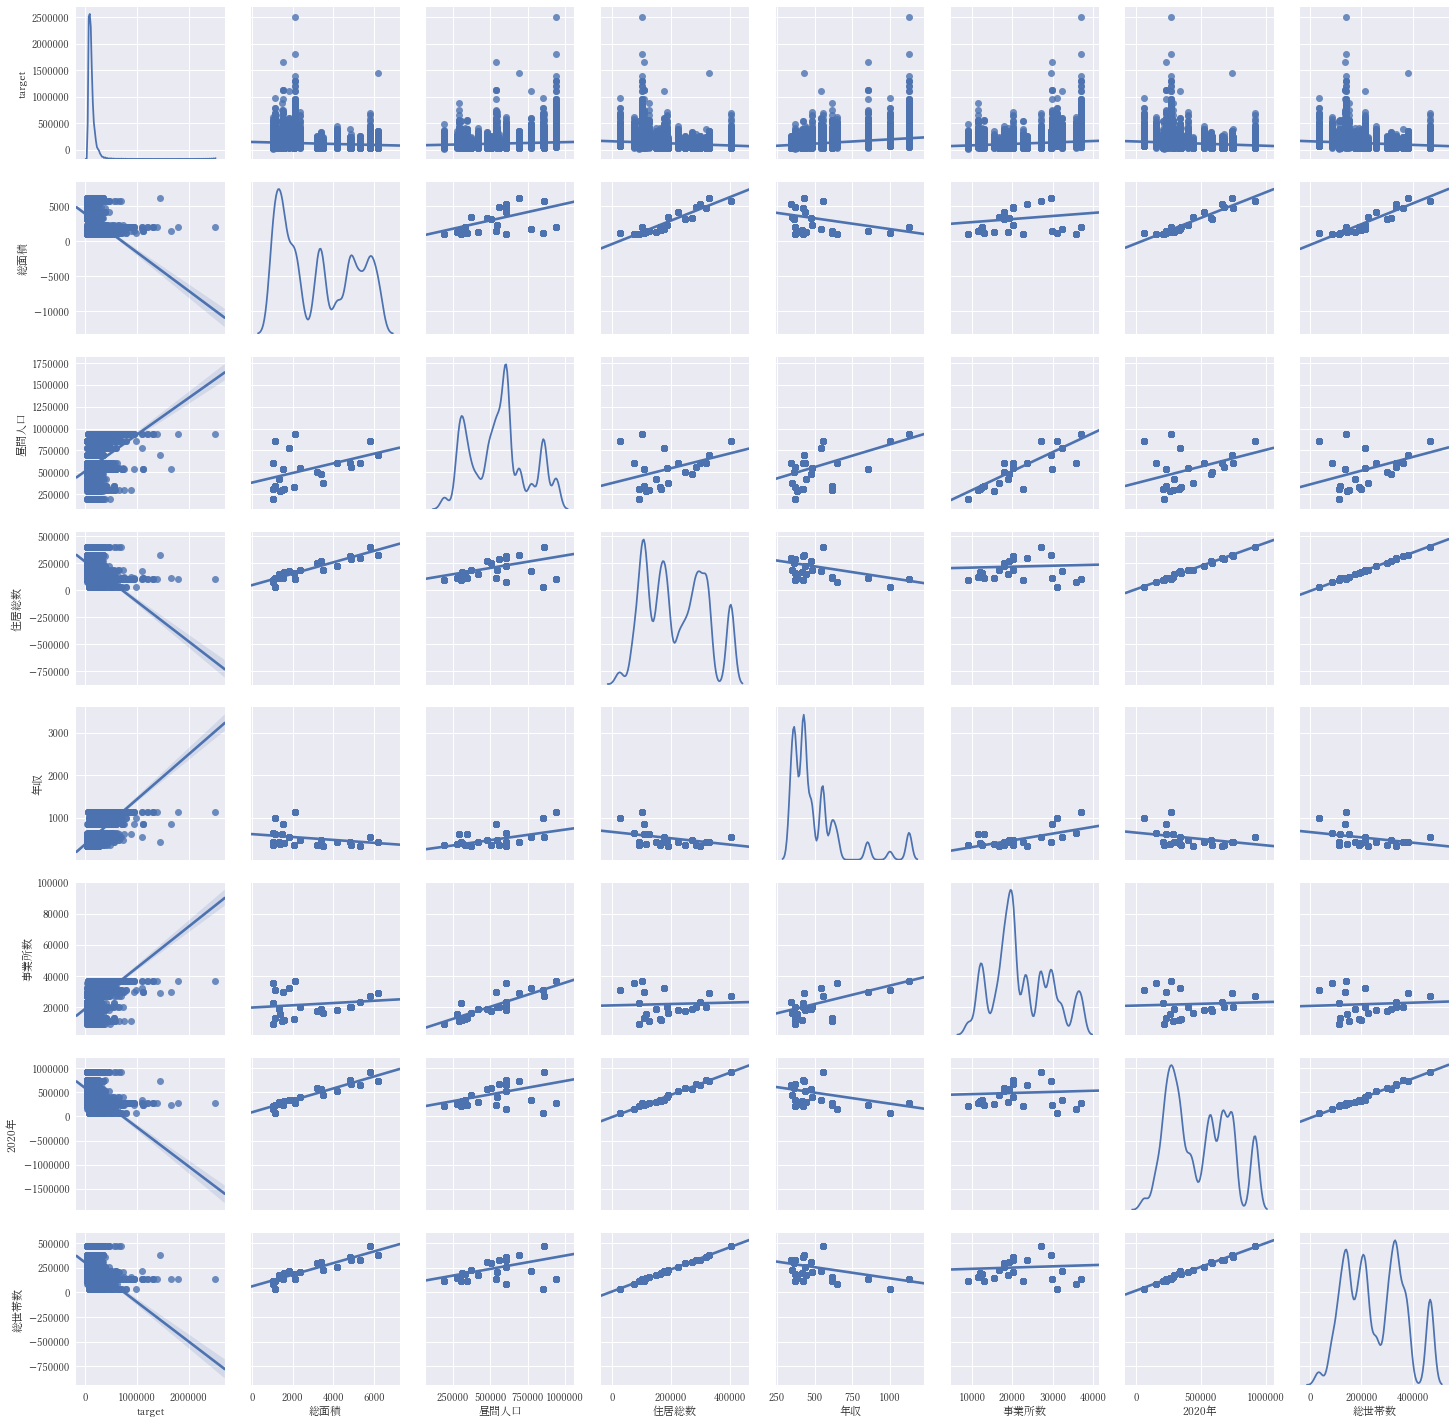

In [173]:
plt.figure(figsize=(15,12))
sns.pairplot(train[['target','総面積','昼間人口','住居総数','年収','事業所数','2020年','総世帯数']],kind='reg', diag_kind='kde')

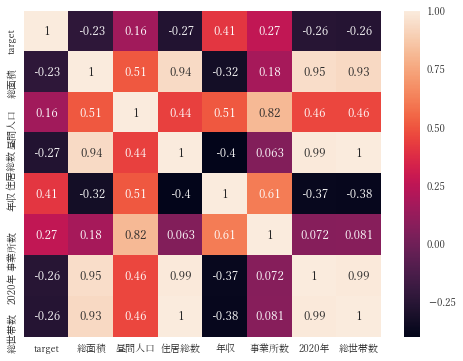

In [172]:
plt.figure(figsize=(8,6))
corr = train[['target','総面積','昼間人口','住居総数','年収','事業所数','2020年','総世帯数']].corr()
sns.heatmap(corr,annot=True)

### 間取り×面積

In [222]:
## m2を削除する
train['area'] = train.area.apply(lambda x: x.rstrip('m2')).replace('','0').astype(float)
test['area'] = test.area.apply(lambda x: x.rstrip('m2')).replace('','0').astype(float)

## 面積を小数点で分ける
train['area_int'] = train.area.astype(int)
test['area_int'] = test.area.astype(int)

train['area_decimal'] = train.area - train.area.astype(int)
test['area_decimal'] = test.area - test.area.astype(int)

In [178]:
## 納戸ダミー
train['S'] = train.floor_plan.apply(lambda x: 1 if '納戸' in x else 0)
test['S'] = test.floor_plan.apply(lambda x: 1 if '納戸' in x else 0)

In [179]:
## 納戸を抜いた間取りを別どり
train['floor_plan'] = train.floor_plan.apply(lambda x: x.replace('(納戸)','').replace('+S',''))
test['floor_plan'] = test.floor_plan.apply(lambda x: x.replace('(納戸)','').replace('+S',''))

train['ishitsu'] = train.floor_plan.apply(lambda x:int(re.sub('\\D', '', x)))
test['ishitsu'] = test.floor_plan.apply(lambda x:int(re.sub('\\D', '', x)))

train['L'] = train.floor_plan.apply(lambda x:1 if 'L' in x else 0)
test['L'] = test.floor_plan.apply(lambda x:1 if 'L' in x else 0)

train['D'] = train.floor_plan.apply(lambda x:1 if 'D' in x else 0)
test['D'] = test.floor_plan.apply(lambda x:1 if 'D' in x else 0)

train['K'] = train.floor_plan.apply(lambda x:1 if 'K' in x else 0)
test['K'] = test.floor_plan.apply(lambda x:1 if 'K' in x else 0)

<Figure size 1080x864 with 0 Axes>

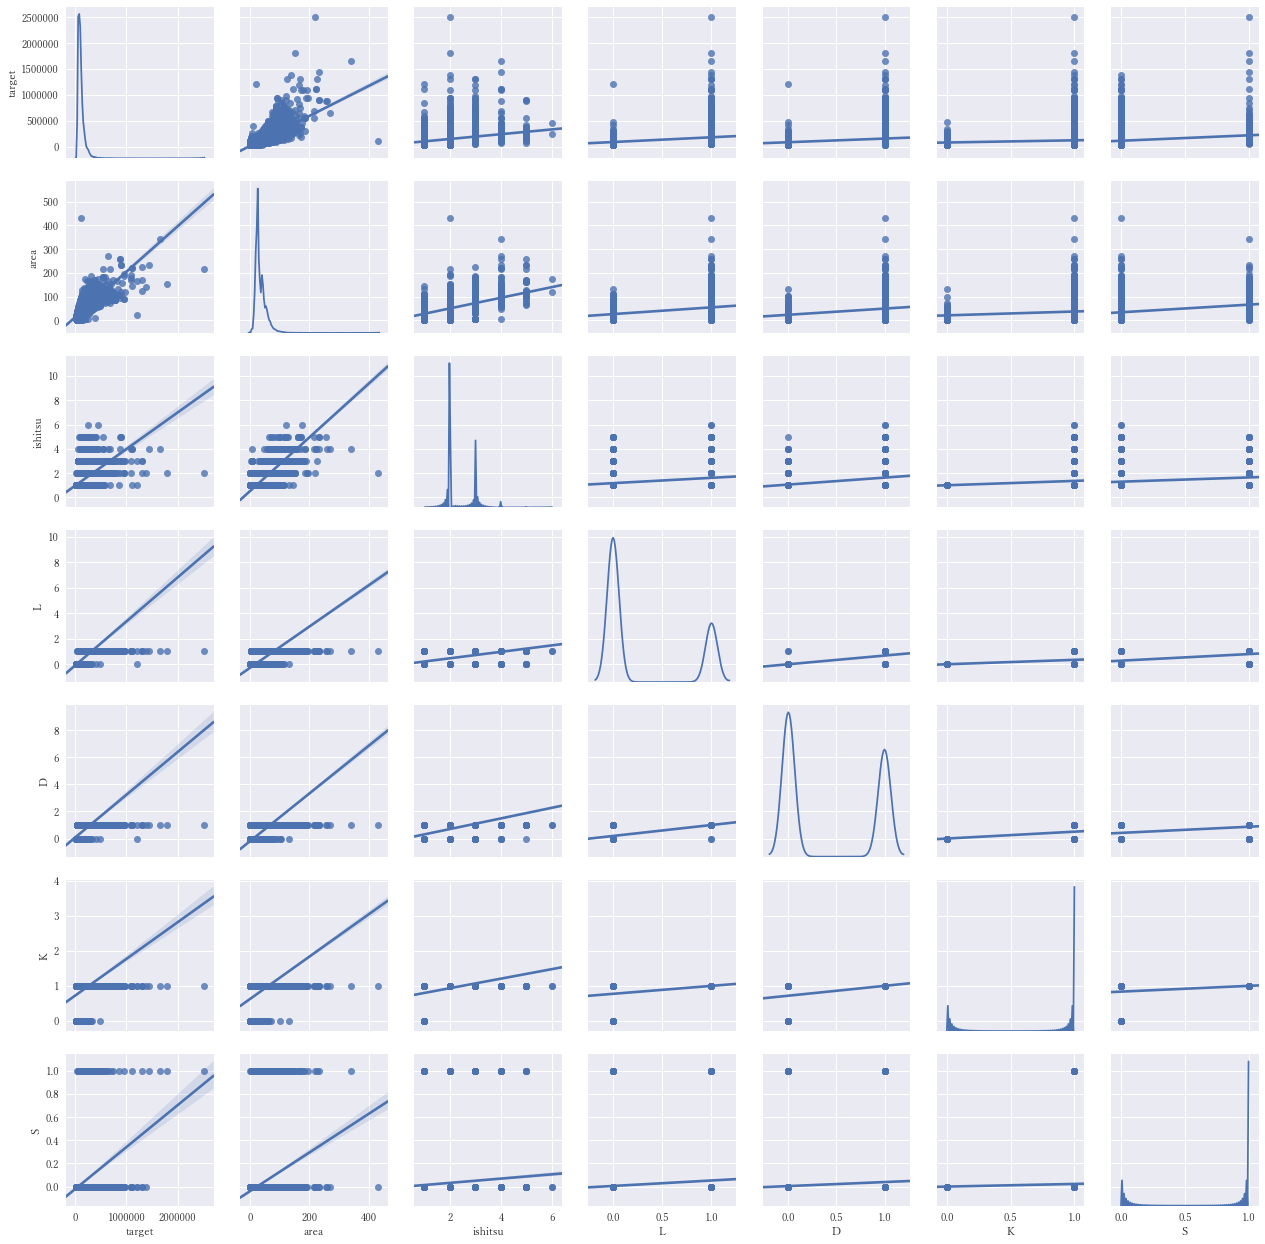

In [181]:
plt.figure(figsize=(15,12))
sns.pairplot(train[['target','area','ishitsu','L','D','K','S']],kind='reg', diag_kind='kde')

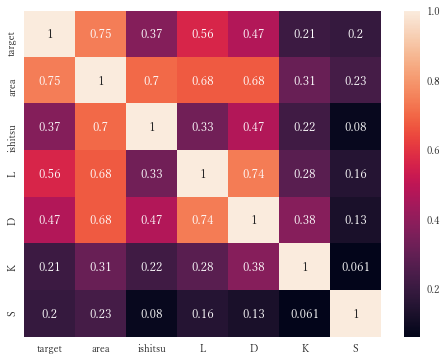

In [182]:
plt.figure(figsize=(8,6))
corr = train[['target','area','ishitsu','L','D','K','S']].corr()
sns.heatmap(corr,annot=True)

### 築年数×契約年数

In [223]:
## 新築フラグ
train['new'] = train.age.apply(lambda x:1 if x=='新築' else 0)
test['new'] = test.age.apply(lambda x: 1 if x=='新築' else 0)

## 新築を0年0カ月に
train['age'] = train.age.apply(lambda x:'0年0ヶ月' if x=='新築' else x)
test['age'] = test.age.apply(lambda x: '0年0ヶ月' if x=='新築' else x)

train['age_year'] = train.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0])))
test['age_year'] = test.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0])))

train['age_month'] = train.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[1])))
test['age_month'] = test.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[1])))

train['age'] = train.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0]))*12 + int(re.sub('\\D', '', x.split('年')[1])))
test['age'] = test.age.apply(lambda x: int(re.sub('\\D', '', x.split('年')[0]))*12 + int(re.sub('\\D', '', x.split('年')[1])))

In [225]:
## 築年数の外れ値を削除
train = train.query('age<6000')

In [226]:
##　契約の月数を数える
train['C_year_num'] = train.C_year.apply(lambda x:x.split()[0])
test['C_year_num'] = test.C_year.apply(lambda x:x.split()[0])

## 「まで」かどうか
train['made'] = train.C_year.apply(lambda x: 1 if 'まで' in x else 0)
test['made'] = test.C_year.apply(lambda x: 1 if 'まで' in x else 0)

## 年だけをみる
train['C_year_y'] = train.C_year_num.apply(lambda x: int(x.split('年間')[0]) if '年間' in x
                                         else int(x.split('年')[0]) if ('月間' in x) and ('年' in x)
                                         else int(0) if '月間' in x
                                         else (int(re.sub('\\D', '', x.split('年')[0]))-2019)  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>=0)
                                         else (int(re.sub('\\D', '', x.split('年')[0]))-2020)
                                                 if  'まで' in x
                                         else x)

test['C_year_y'] = test.C_year_num.apply(lambda x: int(x.split('年間')[0]) if '年間' in x
                                         else int(x.split('年')[0]) if ('月間' in x) and ('年' in x)
                                         else int(0) if '月間' in x
                                         else (int(re.sub('\\D', '', x.split('年')[0]))-2019)  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>=0)
                                         else (int(re.sub('\\D', '', x.split('年')[0]))-2020)
                                                 if  'まで' in x
                                         else x)

train['C_year_y'] = train.C_year_y.apply(lambda x: int(x) if x!='-' else 0)
test['C_year_y'] = test.C_year_y.apply(lambda x: int(x) if x!='-' else 0)

## 月だけをみる
train['C_year_m'] = train.C_year_num.apply(lambda x: 0 if '年間' in x
                                         else int(re.sub('\\D', '', x.split('年')[1])) if ('月間' in x) and ('年' in x)
                                         else int(re.sub('\\D','',x)) if '月間' in x
                                         else int(re.sub('\\D', '', x.split('年')[1]))-10  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>=0)
                                         else 13+(int(re.sub('\\D', '', x.split('年')[1]))-10)
                                                 if  'まで' in x
                                         else x)

test['C_year_m'] = test.C_year_num.apply(lambda x: 0 if '年間' in x
                                         else int(re.sub('\\D', '', x.split('年')[1])) if ('月間' in x) and ('年' in x)
                                         else int(re.sub('\\D','',x)) if '月間' in x
                                         else int(re.sub('\\D', '', x.split('年')[1]))-10  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>=0)
                                         else 13+(int(re.sub('\\D', '', x.split('年')[1]))-10)
                                                 if  'まで' in x
                                         else x)

train['C_year_m'] = train.C_year_m.apply(lambda x: int(x) if x!='-' else 0)
test['C_year_m'] = test.C_year_m.apply(lambda x: int(x) if x!='-' else 0)

## 合計契約月数
train['C_year_num'] = train.C_year_num.apply(lambda x: 12*int(x.split('年間')[0]) if '年間' in x
                                         else 12*int(x.split('年')[0])+int(re.sub('\\D', '', x.split('年')[1])) if ('月間' in x) and ('年' in x)
                                         else int(re.sub('\\D','',x)) if '月間' in x
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2019)+(int(re.sub('\\D', '', x.split('年')[1]))-10)  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>=0)
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2020)+13+(int(re.sub('\\D', '', x.split('年')[1]))-10)
                                                 if  'まで' in x
                                         else x)

test['C_year_num'] = test.C_year_num.apply(lambda x: 12*int(x.split('年間')[0]) if '年間' in x
                                         else 12*int(x.split('年')[0])+int(re.sub('\\D', '', x.split('年')[1])) if ('月間' in x) and ('年' in x)
                                         else int(re.sub('\\D','',x)) if '月間' in x
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2019)+(int(re.sub('\\D', '', x.split('年')[1]))-10)  
                                                 if ('まで' in x)and (int(re.sub('\\D', '', x.split('年')[1]))-10>=0)
                                         else 12*(int(re.sub('\\D', '', x.split('年')[0]))-2020)+13+(int(re.sub('\\D', '', x.split('年')[1]))-10)
                                                 if  'まで' in x
                                         else x)

train['C_year_num'] = train.C_year_num.apply(lambda x: int(x) if x!='-' else 0)
test['C_year_num'] = test.C_year_num.apply(lambda x: int(x) if x!='-' else 0)


## 借家フラグ
train['fixed_term'] = train.C_year.apply(lambda x: 1 if '定期借家' in x else 0)
test['fixed_term'] = test.C_year.apply(lambda x: 1 if '定期借家' in x else 0)

<Figure size 864x576 with 0 Axes>

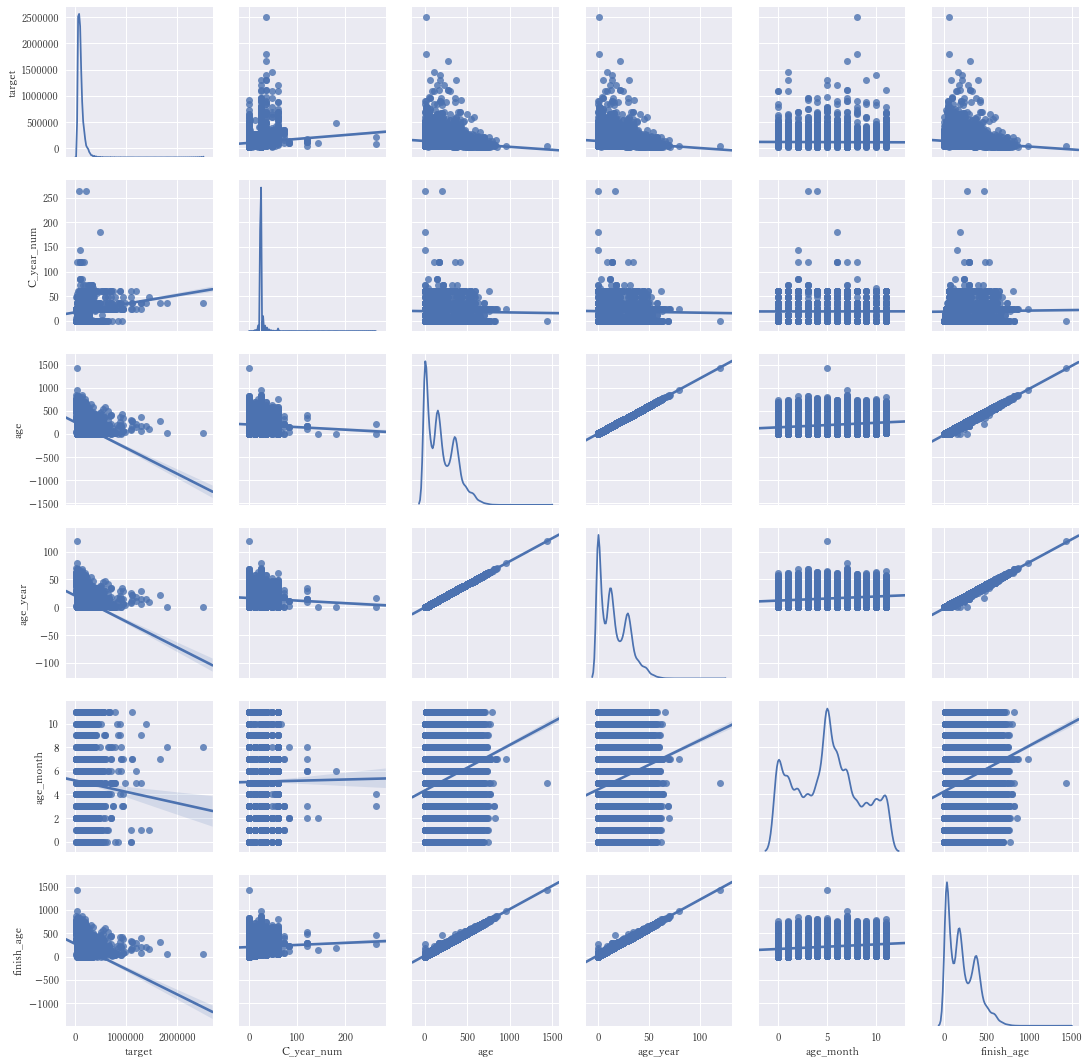

In [206]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','C_year_num','age','age_year','age_month']],kind='reg', diag_kind='kde')

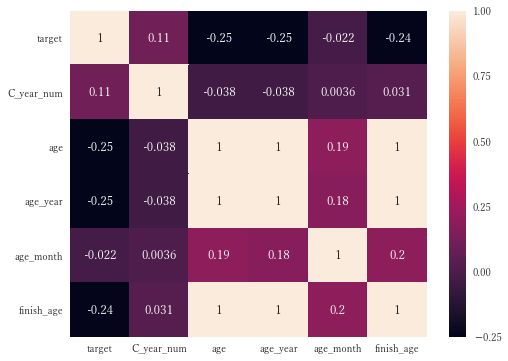

In [207]:
plt.figure(figsize=(8,6))
corr = train[['target','C_year_num','age','age_year','age_month']].corr()
sns.heatmap(corr,annot=True)

In [208]:
## 対数変換
train['age_log'] = train.age.apply(lambda x: np.log1p(x))
test['age_log'] = test.age.apply(lambda x: np.log1p(x))

train['C_year_log'] = train.C_year_num.apply(lambda x: np.log1p(x))
test['C_year_log'] = test.C_year_num.apply(lambda x: np.log1p(x))

<Figure size 864x576 with 0 Axes>

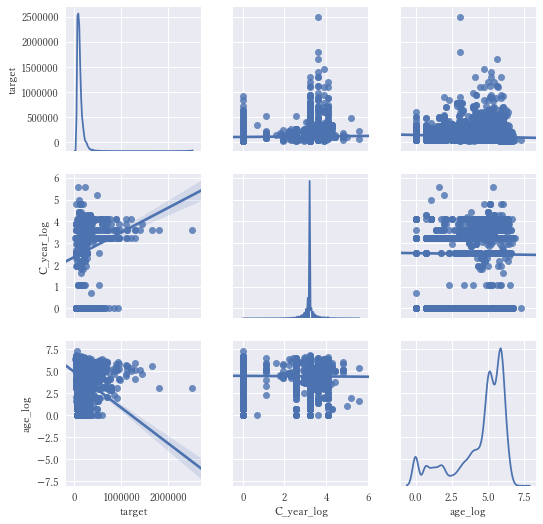

In [213]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','C_year_log','age_log']],kind='reg', diag_kind='kde')

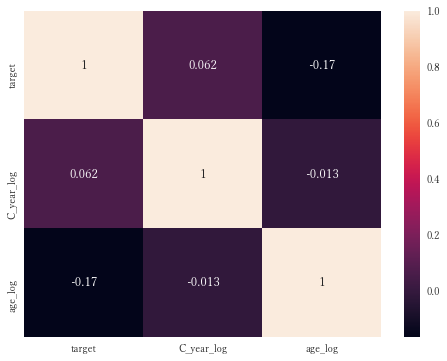

In [209]:
plt.figure(figsize=(8,6))
corr = train[['target','C_year_log','age_log']].corr()
sns.heatmap(corr,annot=True)

### 減価償却・契約年数の割合

In [234]:
train['genka'] = train['area']/(test['age']+1)
test['genka'] = test['area']/(test['age']+1)

train['C_rate'] = train['C_year_num']/(test['age']+1)
test['C_rate'] = test['C_year_num']/(test['age']+1)

<Figure size 864x576 with 0 Axes>

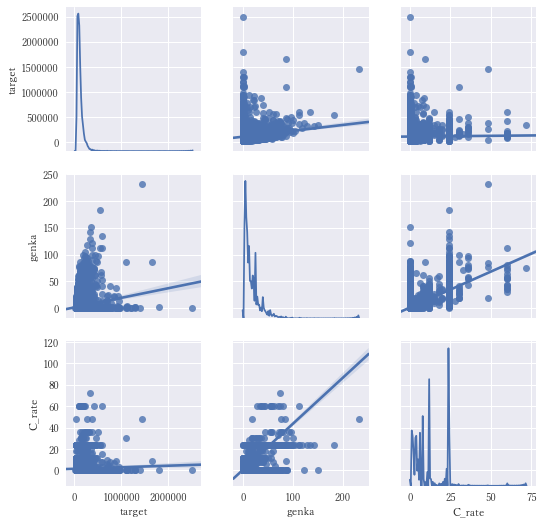

In [235]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','genka','C_rate']],kind='reg', diag_kind='kde')

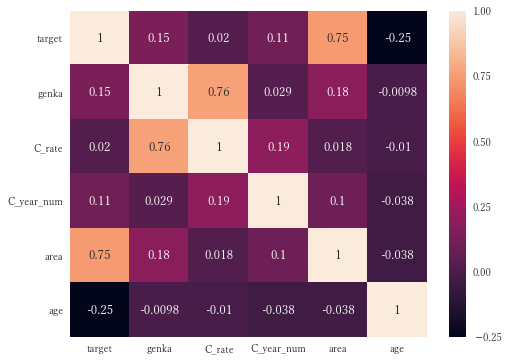

In [236]:
plt.figure(figsize=(8,6))
corr = train[['target','genka','C_rate','C_year_num','area','age']].corr()
sns.heatmap(corr,annot=True)

### 所在階
階数の平均でターゲットエンコーディング

In [372]:
## testの欠損値を埋める
test['Floor'] = test['Floor'].replace('-','-0階')

In [373]:
## 総階数
train['total_Floor'] = train.Floor.apply(lambda x: str(x).split('／')[1] if len(str(x).split('／'))>1 else x)
test['total_Floor'] = test.Floor.apply(lambda x: str(x).split('／')[1] if len(str(x).split('／'))>1 else x)

## 戸建てをダミー変数に、地下階数がある場合は別途記載
train['kodate'] = train.Floor.apply(lambda x: 0 if '／' in str(x) else 1)
test['kodate'] = test.Floor.apply(lambda x: 0 if '／' in str(x) else 1)

## 地下付きフラグ
train['chika'] = train.Floor.apply(lambda x: int(re.sub('\\D', '', str(x).split('地下')[1].split('階')[0])) if '地下' in str(x) else 0)
test['chika'] = test.Floor.apply(lambda x: int(re.sub('\\D', '', str(x).split('地下')[1].split('階')[0])) if '地下' in str(x) else 0)

## 地上の総階数を数値化
train['total_Floor'] = train.total_Floor.apply(lambda x: str(x).split('階')[0]).astype('int')
test['total_Floor'] = test.total_Floor.apply(lambda x: str(x).split('階')[0]).astype('int')

## 地下もtotal_Floorに含める
#train['total_Floor'] = train['total_Floor'] + (-1)*train['chika']
#test['total_Floor'] = test['total_Floor'] + (-1)*test['chika']

## 所在階を数値に
train['_Floor'] = train.Floor.apply(lambda x: str(x).split('／')[0] if len(str(x).split('／'))>1 else x)
test['_Floor'] = test.Floor.apply(lambda x: str(x).split('／')[0] if len(str(x).split('／'))>1 else x)

train['_Floor'] = train._Floor.apply(lambda x: '-'+ str(x).split('階')[0].replace('地下','') if '地下' in str(x).split('階')[0] 
                                     else str(x).split('階')[0])
test['_Floor'] = test._Floor.apply(lambda x: '-'+ str(x).split('階')[0].replace('地下','') if '地下' in str(x).split('階')[0] 
                                   else str(x).split('階')[0])

train['_Floor'] = train['_Floor'].replace('',0).astype(int)
test['_Floor'] = test['_Floor'].replace('',0).astype(int)

In [252]:
## 面積の総階数における割合
train['area_floor'] = train['area']/(train['total_Floor']+1)
test['area_floor'] = test['area']/(test['total_Floor']+1)

## 総階数の築年数における減価償却
train['floor_age'] = train['total_Floor']/(train['age']+1)
test['floor_age'] = test['total_Floor']/(test['age']+1)

In [385]:
## 総階数に対して所在階数は何パーセントの位置か
train['Floor_rate'] = train['_Floor'] / train['total_Floor']
test['Floor_rate'] = test['_Floor'] / test['total_Floor']

## 最上階フラグ
train['Floor_rate'] = train['Floor_rate'].apply(lambda x: 1 if x>0.9 else 0)
test['Floor_rate'] = test['Floor_rate'].apply(lambda x: 1 if x>0.9 else 0)
train['Floor_rate'] = train['Floor_rate'] - train['kodate']
test['Floor_rate'] = test['Floor_rate'] - test['kodate']


"\n## 最上階フラグ\ntrain['Floor_rate'] = train['Floor_rate'].apply(lambda x: 1 if x>0.9 else 0)\ntest['Floor_rate'] = test['Floor_rate'].apply(lambda x: 1 if x>0.9 else 0)\ntrain['Floor_rate'] = train['Floor_rate'] - train['kodate']\ntest['Floor_rate'] = test['Floor_rate'] - test['kodate']\n"

<Figure size 864x576 with 0 Axes>

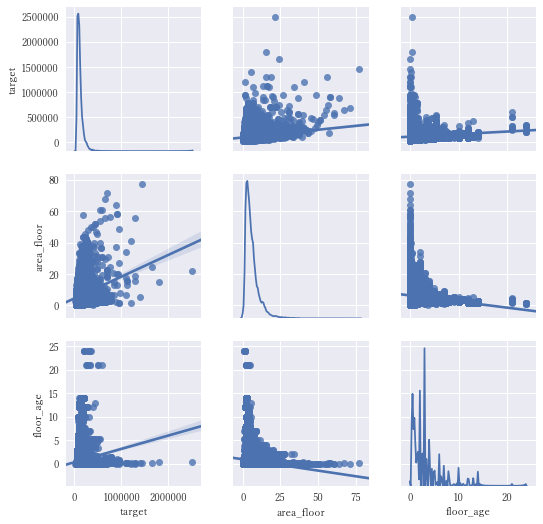

In [253]:
plt.figure(figsize=(12,8))
sns.pairplot(train[['target','area_floor','floor_age']],kind='reg', diag_kind='kde')

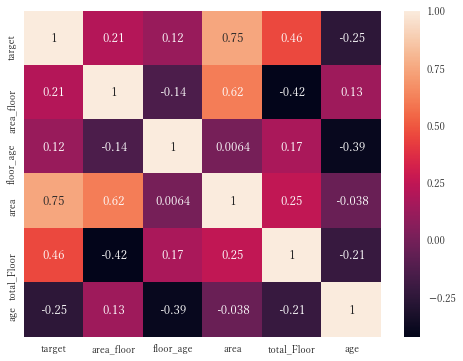

In [255]:
plt.figure(figsize=(8,6))
corr = train[['target','area_floor','floor_age','area','total_Floor','age']].corr()
sns.heatmap(corr,annot=True)

4階／2階建とかわけわからんものも混じっている

階数が高くなればなるほど高くなる

### 戸建て×建物構造

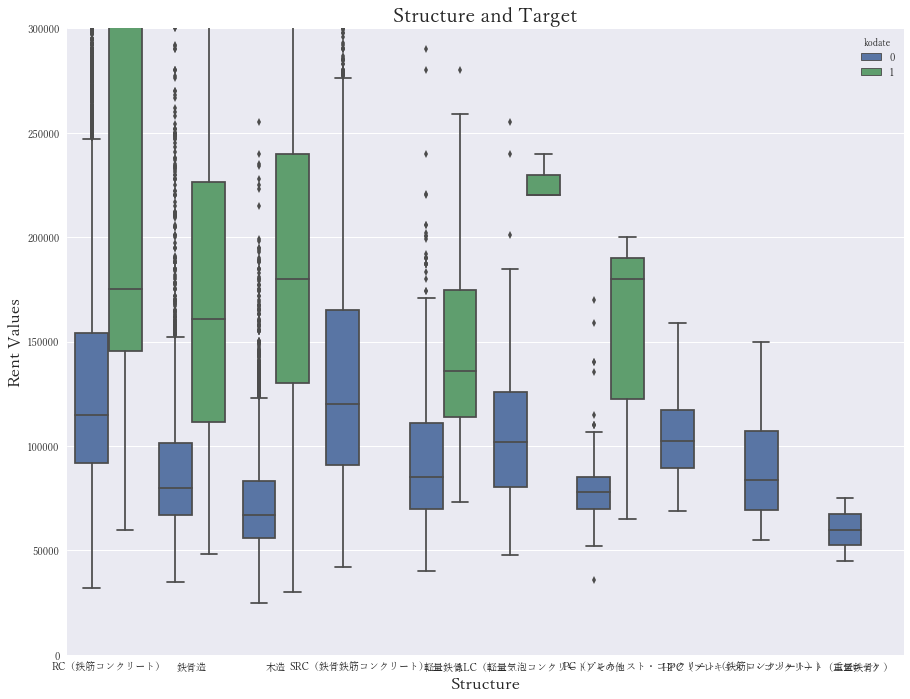

In [375]:
total = len(train)
plt.figure(figsize=(15,12))
g2 = sns.boxplot(x='structure', y='target',hue='kodate', data=train )
g2.set_title("Structure and Target", fontsize=20)
g2.set_xlabel("Structure", fontsize=17)
g2.set_ylabel("Rent Values", fontsize=17)
g2.set_ylim(0,300000)
plt.subplots_adjust(hspace = 0.6, top = 0.85)
plt.show()

In [376]:
train.groupby(['structure','kodate']).target.describe().sort_values('mean')

,,count,mean,std,min,25%,50%,75%,max
structure,kodate,,,,,,,,
ブロック,0,3.0,60000.000000,15000.000000,45000.0,52500.0,60000.0,67500.0,75000.0
木造,0,5062.0,73299.182141,26123.122923,25000.0,56000.0,67000.0,83000.0,255000.0
その他,0,133.0,80221.992481,18657.198890,36000.0,70000.0,78000.0,85000.0,170000.0
鉄骨造,0,3696.0,91296.357143,50641.898275,35000.0,67000.0,80000.0,101200.0,1390000.0
軽量鉄骨,0,1729.0,91631.108155,30156.151371,40000.0,70000.0,85000.0,111000.0,290000.0
HPC（プレキャスト・コンクリート（重量鉄骨））,0,4.0,93000.000000,41044.691090,55000.0,69250.0,83500.0,107250.0,150000.0
ALC（軽量気泡コンクリート）,0,294.0,105883.673469,31813.323975,48000.0,80250.0,102000.0,126000.0,255000.0
PC（プレキャスト・コンクリート（鉄筋コンクリート））,0,46.0,106195.652174,21821.110640,69000.0,89250.0,102500.0,117250.0,159000.0
RC（鉄筋コンクリート）,0,17480.0,134130.697254,77477.833585,32000.0,92000.0,115000.0,154000.0,2500000.0


### アクセス
**一回保留**  
- [東京23区の家賃相場が安い駅](https://suumo.jp/journal/2019/03/18/163064/)  

最寄り駅はどこか、何分かかるか、バス使うのか

In [387]:
## 最寄り駅を線、駅名、かかる時間に分ける
train['line'] = train['access'].apply(lambda x: x.split()[0])
test['line'] = test['access'].apply(lambda x: x.split()[0])

train['station'] = train['access'].apply(lambda x: x.split()[1])
test['station'] = test['access'].apply(lambda x: x.split()[1])


train['cost'] = train['access'].apply(lambda x: x.split()[2].replace('/',''))
test['cost'] = test['access'].apply(lambda x: x.split()[2].replace('/',''))

train['cost2'] = train['access'].apply(lambda x: x.split()[3] if len(x.split())>=4 else '')
test['cost2'] = test['access'].apply(lambda x: x.split()[3] if len(x.split())>=4 else '')

train['cost2'] = train.cost2.apply(lambda x: x if re.search("[0-9]",x) else  '')
test['cost2'] = test.cost2.apply(lambda x: x if re.search("[0-9]",x) else  '')

train['cost'] = train['cost'] + train['cost2']
test['cost'] = test['cost'] + test['cost2']

train.drop('cost2',axis=1, inplace=True)
test.drop('cost2',axis=1, inplace=True)

In [388]:
## もっと近い駅がある場合
train.loc[610,'station'] = '武蔵関駅'
train.loc[610,'line'] = '西武新宿線'
train.loc[610,'cost'] = '徒歩8分'
train.loc[682,'station'] = '篠崎駅'
train.loc[682,'line'] = '都営新宿線'
train.loc[682,'cost'] = '徒歩23分'
train.loc[943,'station'] = '桜上水駅'
train.loc[943,'line'] = '京王線'
train.loc[943,'cost'] = '徒歩4分'
train.loc[1548,'station'] = '武蔵関駅'
train.loc[1548,'line'] = '西武新宿線'
train.loc[1548,'cost'] = '徒歩7分'
train.loc[1924,'station'] = '東中野駅'
train.loc[1924,'line'] = '総武線・中央線（各停）'
train.loc[1924,'cost'] = '徒歩12分'
train.loc[2012,'station'] = '武蔵関駅'
train.loc[2012,'line'] = '西武新宿線'
train.loc[2012,'cost'] = '徒歩8分'
train.loc[2474,'station'] = '谷塚駅'
train.loc[2474,'line'] = '東武スカイツリーライン'
train.loc[2474,'cost'] = '徒歩26分'
train.loc[3926,'station'] = '扇大橋駅'
train.loc[3926,'line'] = '日暮里・舎人ライナー'
train.loc[3926,'cost'] = '扇大橋駅'
train.loc[5369,'station'] = '武蔵関駅'
train.loc[5369,'line'] = '西武新宿線'
train.loc[5369,'cost'] = '徒歩8分'
train.loc[5875,'station'] = '池尻大橋駅'
train.loc[5875,'line'] = '東急田園都市線'
train.loc[5875,'cost'] = '徒歩14分'
train.loc[6463,'station'] = '扇大橋駅'
train.loc[6463,'line'] = '日暮里・舎人ライナー'
train.loc[6463,'cost'] = '徒歩4分'
train.loc[6591,'station'] = '武蔵関駅'
train.loc[6591,'line'] = '西武新宿線'
train.loc[6591,'cost'] = '徒歩8分'
train.loc[7630,'station'] = '武蔵関駅'
train.loc[7630,'line'] = '西武新宿線'
train.loc[7630,'cost'] = '徒歩3分'
train.loc[8003,'station'] = '新中野駅'
train.loc[8003,'line'] = '丸ノ内線(池袋－荻窪)'
train.loc[8003,'cost'] = '徒歩9分'
train.loc[8709,'station'] = '八潮駅'
train.loc[8709,'line'] = 'つくばエクスプレス'
train.loc[8709,'cost'] = '徒歩22分'
train.loc[8869,'station'] = '八潮駅'
train.loc[8869,'line'] = 'つくばエクスプレス'
train.loc[8869,'cost'] = '徒歩14分'
train.loc[9338,'station'] = '武蔵関駅'
train.loc[9338,'line'] = '西武新宿線'
train.loc[9338,'cost'] = '徒歩7分'
train.loc[9503,'station'] = '葛西臨海公園駅'
train.loc[9503,'line'] = '京葉線(東京－蘇我)'
train.loc[9503,'cost'] = '徒歩13分'
train.loc[9848,'station'] = '葛西臨海公園駅'
train.loc[9848,'line'] = '京葉線(東京－蘇我)'
train.loc[9848,'cost'] = '徒歩22分'
train.loc[12146,'station'] = '上石神井駅'
train.loc[12146,'line'] = '西武新宿線'
train.loc[12146,'cost'] = '徒歩8分'
train.loc[12557,'station'] = '北綾瀬駅'
train.loc[12557,'line'] = '千代田線'
train.loc[12557,'cost'] = '徒歩23分'
train.loc[12581,'station'] = '町屋(東京メトロ)駅'
train.loc[12581,'line'] = '千代田線'
train.loc[12581,'cost'] = '徒歩8分'
train.loc[12808,'station'] = '東中野駅'
train.loc[12808,'line'] = '都営大江戸線'
train.loc[12808,'cost'] = '徒歩13分'
train.loc[12823,'station'] = '沼袋駅'
train.loc[12823,'line'] = '西武新宿線'
train.loc[12823,'cost'] = '徒歩12分'
train.loc[13123,'station'] = '八潮駅'
train.loc[13123,'line'] = 'つくばエクスプレス'
train.loc[13123,'cost'] = '徒歩22分'
train.loc[13507,'station'] = '亀有駅'
train.loc[13507,'line'] = '常磐線'
train.loc[13507,'cost'] = '徒歩25分'
train.loc[15240,'station'] = '上石神井駅'
train.loc[15240,'line'] = '西武新宿線'
train.loc[15240,'cost'] = '徒歩11分'
train.loc[16308,'station'] = '祖師ケ谷大蔵駅'
train.loc[16308,'line'] = '小田急小田原線'
train.loc[16308,'cost'] = '徒歩18分'
train.loc[17262,'station'] = '武蔵関駅'
train.loc[17262,'line'] = '西武新宿線'
train.loc[17262,'cost'] = '徒歩9分'
train.loc[17280,'station'] = '竹ノ塚駅'
train.loc[17280,'line'] = '東武スカイツリーライン'
train.loc[17280,'cost'] = '徒歩34分'
train.loc[17408,'station'] = '中井駅'
train.loc[17408,'line'] = '西武新宿線'
train.loc[17408,'cost'] = '徒歩11分'
train.loc[18051,'station'] = '八潮駅'
train.loc[18051,'line'] = 'つくばエクスプレス'
train.loc[18051,'cost'] = '徒歩22分'
train.loc[18998,'station'] = '扇大橋駅'
train.loc[18998,'line'] = '日暮里・舎人ライナー'
train.loc[18998,'cost'] = '徒歩17分'
train.loc[19724,'station'] = '池尻大橋駅'
train.loc[19724,'line'] = '東急田園都市線'
train.loc[19724,'cost'] = '徒歩14分'
train.loc[20556,'station'] = '武蔵関駅'
train.loc[20556,'line'] = '西武新宿線'
train.loc[20556,'cost'] = '徒歩6分'
train.loc[21102,'station'] = '扇大橋駅'
train.loc[21102,'line'] = '日暮里・舎人ライナー'
train.loc[21102,'cost'] = '徒歩15分'
train.loc[21491,'station'] = '扇大橋駅'
train.loc[21491,'line'] = '日暮里・舎人ライナー'
train.loc[21491,'cost'] = '徒歩18分'
train.loc[21923,'station'] = '武蔵関駅'
train.loc[21923,'line'] = '西武新宿線'
train.loc[21923,'cost'] = '徒歩6分'
train.loc[24103,'station'] = '池尻大橋駅'
train.loc[24103,'line'] = '東急田園都市線'
train.loc[24103,'cost'] = '徒歩14分'
train.loc[24576,'station'] = '六町駅'
train.loc[24576,'line'] = 'つくばエクスプレス'
train.loc[24576,'cost'] = '徒歩19分'
train.loc[25446,'station'] = '志村三丁目駅'
train.loc[25446,'line'] = '都営三田線'
train.loc[25446,'cost'] = '徒歩5分'
train.loc[27410,'station'] = '竹ノ塚駅'
train.loc[27410,'line'] = '東武スカイツリーライン'
train.loc[27410,'cost'] = '徒歩34分'
train.loc[28380,'station'] = '武蔵関駅'
train.loc[28380,'line'] = '西武新宿線'
train.loc[28380,'cost'] = '徒歩10分'
train.loc[29579,'station'] = '平和島駅'
train.loc[29579,'line'] = '京急本線'
train.loc[29579,'cost'] = '徒歩19分'
train.loc[30139,'station'] = '西新井駅'
train.loc[30139,'line'] = '東武スカイツリーライン'
train.loc[30139,'cost'] = '徒歩23分'
train.loc[30500,'station'] = '上石神井駅'
train.loc[30500,'line'] = '西武新宿線'
train.loc[30500,'cost'] = '徒歩13分'
train.loc[31298,'station'] = '梅島駅'
train.loc[31298,'line'] = '東武スカイツリーライン'
train.loc[31298,'cost'] = '徒歩17分'

In [389]:
## テストデータの修正
test.loc[4177,'station'] = '葛西臨海公園駅'
test.loc[4177,'line'] = '京葉線(東京－蘇我)'
test.loc[4177,'cost'] = '徒歩19分'
test.loc[4448,'station'] = '千川駅'
test.loc[4448,'line'] = '有楽町線'
test.loc[4448,'cost'] = '徒歩2分'
test.loc[4533,'station'] = '池尻大橋駅'
test.loc[4533,'line'] = '東急田園都市線'
test.loc[4533,'cost'] = '徒歩14分'
test.loc[7599,'station'] = '八潮駅'
test.loc[7599,'line'] = 'つくばエクスプレス'
test.loc[7599,'cost'] = '徒歩18分'
test.loc[7813,'station'] = '池尻大橋駅'
test.loc[7813,'line'] = '東急田園都市線'
test.loc[7813,'cost'] = '徒歩14分'
test.loc[8808,'station'] = '葛西臨海公園駅'
test.loc[8808,'line'] = '京葉線(東京－蘇我)'
test.loc[8808,'cost'] = '徒歩27分'
test.loc[8933,'station'] = '武蔵関駅'
test.loc[8933,'line'] = '西武新宿線'
test.loc[8933,'cost'] = '徒歩9分'
test.loc[9729,'station'] = '昭和島駅'
test.loc[9729,'line'] = '東京モノレール羽田線'
test.loc[9729,'cost'] = '徒歩10分'
test.loc[11054,'station'] = '千歳船橋駅'
test.loc[11054,'line'] = '小田急小田原線'
test.loc[11054,'cost'] = '徒歩15分'
test.loc[11499,'station'] = '扇大橋駅'
test.loc[11499,'line'] = '日暮里・舎人ライナー'
test.loc[11499,'cost'] = '徒歩3分'
test.loc[12589,'station'] = '扇大橋駅'
test.loc[12589,'line'] = '日暮里・舎人ライナー'
test.loc[12589,'cost'] = '徒歩18分'
test.loc[12906,'station'] = '西新井駅'
test.loc[12906,'line'] = '東武スカイツリーライン'
test.loc[12906,'cost'] = '徒歩18分'
test.loc[13711,'station'] = '保谷駅'
test.loc[13711,'line'] = '西武池袋線'
test.loc[13711,'cost'] = '徒歩19分'
test.loc[13812,'station'] = '扇大橋駅'
test.loc[13812,'line'] = '日暮里・舎人ライナー'
test.loc[13812,'cost'] = '徒歩17分'
test.loc[15216,'station'] = '扇大橋駅'
test.loc[15216,'line'] = '日暮里・舎人ライナー'
test.loc[15216,'cost'] = '徒歩15分'
test.loc[16773,'station'] = '王子駅'
test.loc[16773,'line'] = '京浜東北線'
test.loc[16773,'cost'] = '徒歩12分'
test.loc[18146,'station'] = '小台駅'
test.loc[18146,'line'] = '都電荒川線'
test.loc[18146,'cost'] = '徒歩19分'
test.loc[18997,'station'] = '落合南長崎駅'
test.loc[18997,'line'] = '都営大江戸線'
test.loc[18997,'cost'] = '徒歩6分'
test.loc[19859,'station'] = '武蔵関駅'
test.loc[19859,'line'] = '西武新宿線'
test.loc[19859,'cost'] = '徒歩8分'
test.loc[20195,'station'] = '葛西臨海公園駅'
test.loc[20195,'line'] = '京葉線(東京－蘇我)'
test.loc[20195,'cost'] = '徒歩22分'
test.loc[20462,'station'] = '西新井駅'
test.loc[20462,'line'] = '東武スカイツリーライン'
test.loc[20462,'cost'] = '徒歩19分'
test.loc[21160,'station'] = '扇大橋駅'
test.loc[21160,'line'] = '日暮里・舎人ライナー'
test.loc[21160,'cost'] = '徒歩5分'
test.loc[22287,'station'] = '中野新橋駅'
test.loc[22287,'line'] = '丸ノ内線(中野坂上－方南町)'
test.loc[22287,'cost'] = '徒歩10分'
test.loc[22584,'station'] = '西荻窪駅'
test.loc[22584,'line'] = '中央線（快速）'
test.loc[22584,'cost'] = '徒歩20分'
test.loc[23008,'station'] = '池尻大橋駅'
test.loc[23008,'line'] = '東急田園都市線'
test.loc[23008,'cost'] = '徒歩14分'
test.loc[23060,'station'] = '下井草駅'
test.loc[23060,'line'] = '西武新宿線'
test.loc[23060,'cost'] = '徒歩2分'
test.loc[24518,'station'] = '扇大橋駅'
test.loc[24518,'line'] = '日暮里・舎人ライナー'
test.loc[24518,'cost'] = '徒歩16分'
test.loc[24744,'station'] = '祖師ケ谷大蔵駅'
test.loc[24744,'line'] = '小田急小田原線'
test.loc[24744,'cost'] = '徒歩14分'
test.loc[26054,'station'] = '目黒駅'
test.loc[26054,'line'] = '山手線'
test.loc[26054,'cost'] = '徒歩11分'
test.loc[26637,'station'] = '西荻窪駅'
test.loc[26637,'line'] = '中央線（快速）'
test.loc[26637,'cost'] = '徒歩20分'
test.loc[26852,'station'] = '浮間舟渡駅'
test.loc[26852,'line'] = '埼京線'
test.loc[26852,'cost'] = '徒歩9分'
test.loc[27143,'station'] = '上石神井駅'
test.loc[27143,'line'] = '西武新宿線'
test.loc[27143,'cost'] = '徒歩11分'
test.loc[29605,'station'] = '六町駅'
test.loc[29605,'line'] = 'つくばエクスプレス'
test.loc[29605,'cost'] = '徒歩35分'
test.loc[30300,'station'] = '上石神井駅'
test.loc[30300,'line'] = '西武新宿線'
test.loc[30300,'cost'] = '徒歩4分'

In [390]:
## 駅を全てダミー変数に
stations = pd.concat([train[['id','station']],test[['id','station']]])
stations = stations.station.unique()
for sta in tqdm(stations):
    train[sta] = train.access.apply(lambda x: 1 if sta in x else 0)
    test[sta] = test.access.apply(lambda x: 1 if sta in x else 0)
    
## 最寄り駅の数
train['station_num'] = train[stations].sum(axis=1)
test['station_num'] = test[stations].sum(axis=1)
train.drop(stations,axis=1,inplace=True)
test.drop(stations,axis=1,inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████| 474/474 [00:23<00:00, 20.06it/s]


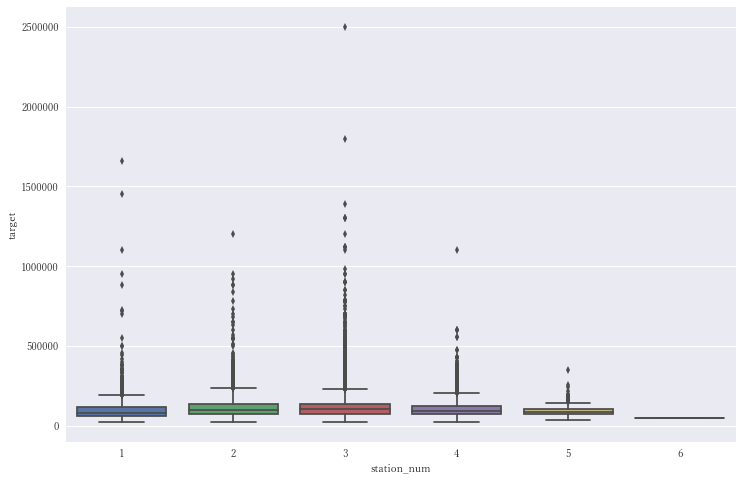

In [358]:
plt.figure(figsize=(12,8))
sns.boxplot(x='station_num',y='target',data=train)

In [37]:
## 最寄り駅の緯度経度追加
## lon, latのマッピング
lat_map = sta.groupby('station')['lat'].max()
lon_map = sta.groupby('station')['lon'].max()
train['sta_lat'] = train.station.map(lat_map)
train['sta_lon'] = train.station.map(lon_map)

test['sta_lat'] = test.station.map(lat_map)
test['sta_lon'] = test.station.map(lon_map)

In [38]:
## 緯度経度のサインコサイン変換
from math import sin, cos
train['sin_sta_lat'] = train.sta_lat.apply(lambda x: sin(radians(x))
train['cos_sta_lon'] = train.sta_lon.apply(lambda x: cos(radians(x))

test['sin_sta_lat'] = test.sta_lat.apply(lambda x: sin(radians(x))
test['cos_sta_lon'] = test.sta_lon.apply(lambda x: cos(radians(x))

## 距離を求める関数
# 国会議事堂の緯度経度[35.6759323, 139.7450316]
import math
import pyproj
from geopy.distance import great_circle, vincenty

# 赤道半径をWGS84準拠で設定
g = pyproj.Geod(ellps='WGS84')

train['station_dis'] = train.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(x['sta_lat'],x['sta_lon'])).meters, axis=1)
test['station_dis'] = test.apply(lambda x: vincenty((x['loc_lat'],x['loc_lon']),(x['sta_lat'],x['sta_lon'])).meters, axis=1)

## 距離が明らかにおかしかった。
train.loc[24812,'station_dis'] = 118.60
train.loc[24401,'station_dis'] = 118.60


 mu = 582.98 and sigma = 354.77



((array([-4.08513702, -3.87431282, -3.75917019, ...,  3.75917019,
          3.87431282,  4.08513702]),
  array([  11.4841566 ,   11.4841566 ,   11.4841566 , ..., 3672.60729449,
         3753.01974465, 3875.48170001])),
 (334.95276175561264, 582.9806031684435, 0.9440276178932049))

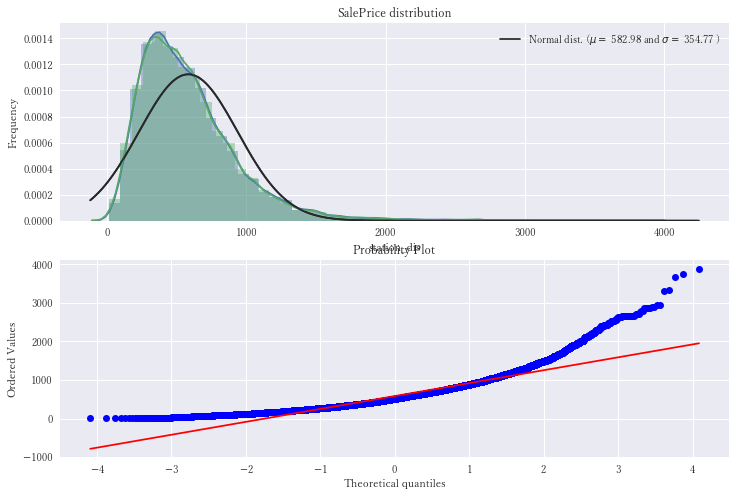

In [39]:
## 確認
plt.figure(figsize=(12,8))
plt.subplot(211)
g = sns.distplot(train['station_dis'],fit=norm)
g = sns.distplot(test['station_dis'],fit=norm)
(mu,sigma) = norm.fit(train['station_dis'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
g.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
g.set_ylabel('Frequency')
g.set_title('SalePrice distribution')

plt.subplot(212)
stats.probplot(train['station_dis'],plot=plt)

In [40]:
pd.concat([train.station_dis.describe().reset_index(),test.station_dis.describe().reset_index()],axis=1)

,index,station_dis,index,station_dis
0,count,31470.000000,count,31262.000000
1,mean,582.980603,mean,580.750103
2,std,354.773236,std,354.791730
3,min,11.484157,min,11.484157
4,25%,333.330787,25%,331.920212
5,50%,511.980445,50%,510.579447
6,75%,747.988819,75%,744.752106
7,max,3875.481700,max,4117.745170


In [41]:
## 賃貸を地図に表示
import folium
sta_map = train.groupby('station')[['target','sta_lat','sta_lon']].median()

map = folium.Map(location=[35.638697, 139.683262], zoom_start=11)
 
for i, r in sta_map.iterrows():
    folium.CircleMarker(location=[r['sta_lat'], r['sta_lon']], popup=r['target'],
                        color='crimson',fill=True,radius=r['target']/50000).add_to(map)
map

<Figure size 864x576 with 0 Axes>

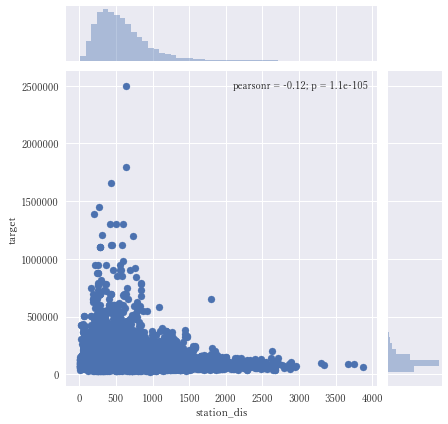

In [42]:
plt.figure(figsize=(12,8))
sns.jointplot(x='station_dis',y='target',data=train)

#### 駅の乗車人数

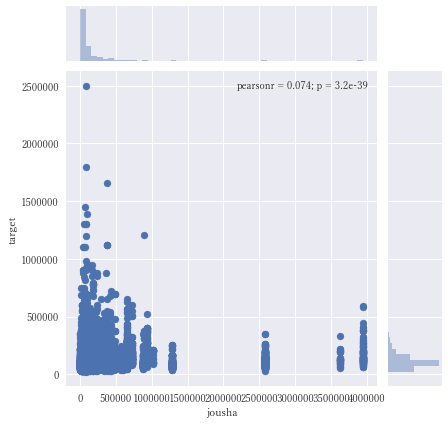

In [49]:
## 駅の乗車人数追加
df = pd.read_csv('../input/tokyo23/station_jousha.csv',encoding='utf-8')
train['station'] = train.station.apply(lambda x: x.replace('(舎人ライナー)','').replace('(東京都)','')\
                                      .replace('(東京メトロ)','').replace('(都営線)','').replace('(西武線)','')\
                                      .replace('(西武線)','').replace('(千葉県)','').replace('(ＴＸ)','').replace('(都電荒川線)',''))
test['station'] = test.station.apply(lambda x: x.replace('(舎人ライナー)','').replace('(東京都)','')\
                                      .replace('(東京メトロ)','').replace('(都営線)','').replace('(西武線)','')\
                                      .replace('(西武線)','').replace('浦安(千葉県)','').replace('(ＴＸ)','').replace('(都電荒川線)',''))

## マッピング
s_map = df.groupby('station').jousha_num.sum()
train['jousha'] = train.station.map(s_map)
test['jousha'] = test.station.map(s_map)
sns.jointplot(x='jousha',y='target',data=train[train['jousha']>0])

### クラスタリング